# Visualising Class Features

In [ ]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


In [ ]:
# imshow function for displaying images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# unzip dataset folder 
!unzip '/content/gdrive/MyDrive/Mushroom_dataset3.zip' > /dev/null

In [ ]:
# dataset directory
data_dir = 'Mushroom_dataset3'

# define batch size
batch_size = 200

# define transforms
transform = transforms.Compose([transforms.Resize(224), # resize to 224x?
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# choose the test dataset
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loader
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

In [ ]:
# for t-SNE we will use a trained network to extract features for each image
# we will remove the final layer of the network so the output a 512 feature vector

# load model
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable

# load a pre-trained ResNet network with 18 layers
model = models.resnet18(pretrained=True)
# # remove the final layer so the output of the network is now a 512 feature vector
model = nn.Sequential(*list(model.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Load previously trained model

# create a new model with ResNet18 architecture
myModel = models.resnet18(pretrained=True)
# get the number of inputs for the final layer (fc) of the network
num_ftrs = myModel.fc.in_features
# replace the final layer so that the output is four classes
myModel.fc = nn.Linear(num_ftrs, 8)
# load previously trained model
myModel.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt'))
# remove the final layer so the output of the network is now a 512 feature vector
myModel = nn.Sequential(*list(myModel.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    myModel.cuda()

# print(myModel)

In [ ]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
imageNet_feats = model(images)
mush_feats = myModel(images)

# put on cpu, convert to numpy array and squeeze to batchsize x 512
imageNet_feats = np.squeeze(imageNet_feats.cpu().detach().numpy())
mush_feats = np.squeeze(mush_feats.cpu().detach().numpy())

labels = labels.numpy()

print(imageNet_feats.shape)
print(mush_feats.shape)
print(labels)

(200, 512)
(200, 512)
[0 5 3 3 4 3 1 0 3 6 2 4 7 3 6 4 0 1 5 6 6 7 2 2 2 5 0 0 4 6 4 4 4 2 4 0 7
 6 3 6 1 1 1 5 1 1 5 7 5 6 7 7 5 2 1 7 2 0 0 3 2 2 2 6 6 0 5 3 1 2 5 5 1 4
 5 7 5 5 3 5 4 7 5 4 4 6 3 5 7 3 5 4 0 4 0 4 1 2 0 1 1 3 1 4 7 3 3 4 0 2 0
 6 0 6 7 5 7 0 2 0 6 2 1 1 0 1 5 4 4 7 0 5 6 5 4 6 6 0 0 7 4 5 3 6 1 3 3 2
 3 0 3 7 0 5 2 6 5 4 0 7 2 6 1 1 6 2 1 3 4 6 0 2 0 1 5 6 4 6 1 1 0 4 2 7 6
 2 2 2 7 7 5 4 0 1 7 0 1 6 7 1]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'mush')

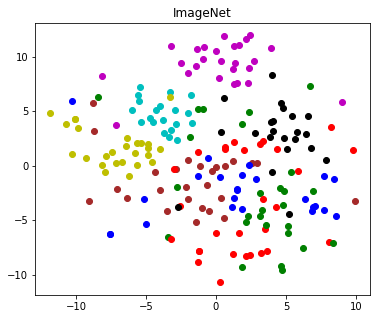

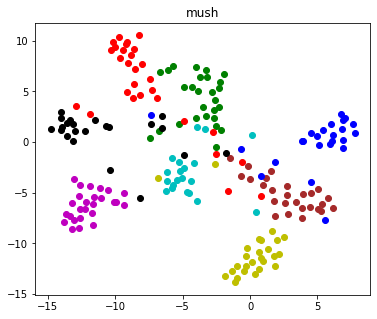

In [ ]:
############################################################
# Fit and transform with a TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0) 

############################################################
# Project the data in 2D
imageNet_X_2d = tsne.fit_transform(imageNet_feats)
mush_X_2d = tsne.fit_transform(mush_feats)

############################################################
# Visualize the data
plt.figure(figsize=(6, 5))
for i in range(imageNet_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 is Amanita phalloides, red
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='r')
  if labels[i] == 1:
    # 1 is Chlorophyllum molybdites, green
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2 is Galerina marginata, blue
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # 3 is Grifola frondosa, cyan
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='c')
  if labels[i] == 4:
    # 4 is Gyromitra esculenta, magenta
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='m')
  if labels[i] == 5:
    # 5 is Hypholoma fasciculare, brown
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='brown')
  if labels[i] == 6:
    # 6 is Laetiporus sulphureus, yellow
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='y')
  if labels[i] == 7:
    # 7 is Suillus luteus, black
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='k')
plt.title('ImageNet')
# plt.show()

# Visualize the data
plt.figure(figsize=(6, 5))
for i in range(mush_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 is Amanita phalloides, red
    plt.scatter(mush_X_2d[i,0], mush_X_2d[i, 1], c='r')
  if labels[i] == 1:
    # 1 is Chlorophyllum molybdites, green
    plt.scatter(mush_X_2d[i,0], mush_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2 is Galerina marginata, blue
    plt.scatter(mush_X_2d[i,0], mush_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # 3 is Grifola frondosa, cyan
    plt.scatter(mush_X_2d[i,0], mush_X_2d[i, 1], c='c')
  if labels[i] == 4:
    # 4 is Gyromitra esculenta, magenta
    plt.scatter(mush_X_2d[i,0], mush_X_2d[i, 1], c='m')
  if labels[i] == 5:
    # 5 is Hypholoma fasciculare, brown
    plt.scatter(mush_X_2d[i,0], mush_X_2d[i, 1], c='brown')
  if labels[i] == 6:
    # 6 is Laetiporus sulphureus, yellow
    plt.scatter(mush_X_2d[i,0], mush_X_2d[i, 1], c='y')
  if labels[i] == 7:
    # 7 is Suillus luteus, black
    plt.scatter(mush_X_2d[i,0], mush_X_2d[i, 1], c='k')
plt.title('mush')
# plt.show()
